In [1]:
import torch
import torch.nn
from torch.distributions import Normal, Beta, Bernoulli, StudentT, MultivariateNormal, Uniform
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor
from causal_cocycle.kernels_new import GaussianKernel, median_heuristic, median_heuristic_ard

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_multiple_conditional_cdfs(Y, weights, num_points=200, smooth=False, epsilon=0.0, labels=None):
    """
    Plots multiple conditional CDF estimates from weights.

    Parameters:
    - Y: tensor of shape (N,) or (N, 1)
    - weights: tensor of shape (N, K) where each column is a set of weights
    - num_points: number of points for y-grid
    - smooth: whether to apply smoothing (e.g., logistic)
    - epsilon: smoothing bandwidth (used if smooth=True)
    - labels: optional list of K labels for each CDF
    """
    Y = Y.flatten()  # (N,)
    N, K = weights.shape

    y_min, y_max = Y.min().item(), Y.max().item()
    y_grid = torch.linspace(y_min - 0.1, y_max + 0.1, num_points)

    cdf_matrix = torch.zeros(num_points, K)

    for j in range(K):  # over conditional CDFs
        w = weights[:, j].flatten()  # shape (N,)

        if smooth and epsilon > 0:
            cdf_vals = torch.stack([
                torch.sum(w * torch.sigmoid((y - Y) / epsilon)) for y in y_grid
            ])
        else:
            cdf_vals = torch.stack([
                torch.sum(w * (Y <= y).float()) for y in y_grid
            ])

        cdf_matrix[:, j] = cdf_vals

    # Plotting
    for j in range(K):
        label = labels[j] if labels and j < len(labels) else f"CDF {j+1}"
        plt.plot(y_grid.numpy(), cdf_matrix[:, j].numpy(), label=label)

    plt.xlabel("y")
    plt.ylabel("Estimated F_{Y|X}(y)")
    plt.title("Multiple Conditional CDF Estimates")
    plt.grid(True)
    plt.legend()
    plt.show()

import torch
import numpy as np

### -----------------------------
### 1. NW Weights via .get_gram()
### -----------------------------

def compute_weights_from_kernel(kernel, Xtrain, x_query):
    """
    Returns normalized weights w_i(x_query) using kernel.get_gram()
    """
    K_vals = kernel.get_gram(x_query.unsqueeze(0), Xtrain).flatten()
    return K_vals / K_vals.sum()


### -----------------------------
### 2. Empirical CDF from Weights
### -----------------------------

def empirical_cdf(y, Y, weights):
    """
    Returns F_x(y) = sum_i w_i * 1{Y_i <= y}
    """
    return torch.sum(weights * (Y <= y).float())


### -----------------------------
### 3. Generalized Quantile (stepwise)
### -----------------------------

def weighted_quantile(Y, weights, alpha_grid):
    """
    Returns Q_x(alpha): inf{y : sum_i w_i * 1{Y_i <= y} >= alpha}
    """
    Y = Y.flatten()
    weights = weights.flatten()
    alpha_grid = alpha_grid.flatten()
    assert torch.isclose(weights.sum(), torch.tensor(1.0), atol=1e-4), "weights must sum to 1"

    sorted_Y, sort_idx = torch.sort(Y)
    sorted_weights = weights[sort_idx]
    cumsum = torch.cumsum(sorted_weights, dim=0)

    quantiles = torch.zeros_like(alpha_grid)
    for i, alpha_val in enumerate(alpha_grid):
        idx = torch.searchsorted(cumsum, alpha_val, right=False)
        quantiles[i] = sorted_Y[min(idx, len(Y) - 1)]
    return quantiles


### -----------------------------
### 4. KR Transport K_{x,x'}(y)
### -----------------------------

def build_KR_transport(Y, w_src, w_tgt):
    """
    Returns function K_{x,x'}(y) = Q_tgt(F_src(y))
    """
    def F_src(y):
        return empirical_cdf(y, Y, w_src)

    def KR(y):
        alpha = F_src(y)
        return weighted_quantile(Y, w_tgt, alpha.unsqueeze(0))[0]

    return KR




### -----------------------------
### 5. Full Counterfactual Pipeline (A, B, C)
### -----------------------------

def full_counterfactual_pipeline(X, Y, kernel):
    """
    Constructs counterfactual outcomes under:
    A: Direct, B: Chain, C: Fork
    """

    device = X.device
    X = X.float()
    Y = Y.float().flatten()
    n = len(Y)

    # Define intervention values
    x_vals = {
        "00": torch.tensor([0.0, 0.0], device=device),
        "10": torch.tensor([1.0, 0.0], device=device),
        "11": torch.tensor([1.0, 1.0], device=device)
    }

    # Precompute fixed weights for intervention targets
    w_fixed = {k: compute_weights_from_kernel(kernel, X, x_vals[k]) for k in x_vals}
    w_i = [compute_weights_from_kernel(kernel, X, X[i]) for i in range(n)]

    # Strategy A: Direct KR maps from each X_i
    A = {
        key: torch.tensor([
            build_KR_transport(Y, w_i[i], w_fixed[key])(Y[i].item()) for i in range(n)
        ])
        for key in ["00", "10", "11"]
    }

    # Strategy B: Sequential path: X_i → (0,0) → (1,0) → (1,1)
    B00 = torch.tensor([
        build_KR_transport(Y, w_i[i], w_fixed["00"])(Y[i].item()) for i in range(n)
    ])
    B10 = torch.tensor([
        build_KR_transport(Y, w_fixed["00"], w_fixed["10"])(B00[i].item()) for i in range(n)
    ])
    B11 = torch.tensor([
        build_KR_transport(Y, w_fixed["10"], w_fixed["11"])(B10[i].item()) for i in range(n)
    ])
    B = {"00": B00, "10": B10, "11": B11}

    # Strategy C: Fork from (0,0)
    C00 = B00  # already computed
    C10 = torch.tensor([
        build_KR_transport(Y, w_fixed["00"], w_fixed["10"])(C00[i].item()) for i in range(n)
    ])
    C11 = torch.tensor([
        build_KR_transport(Y, w_fixed["00"], w_fixed["11"])(C00[i].item()) for i in range(n)
    ])
    C = {"00": C00, "10": C10, "11": C11}

    return A, B, C

In [2]:
mu = torch.zeros(2)
corr = 0.999
cov = torch.eye(2)*(1-corr) + corr*torch.ones((2,2))

In [ ]:
# Setup
trials = 100
n = 1000
nint = 10**4
plot = False

# Looping over instances
As,Bs,Cs = [],[],[]
for t in range(trials):
    torch.manual_seed(t)
    
    #X = torch.sigmoid(StudentT(4,0,1).sample((n,2))/2)
    #X = torch.sigmoid(StudentT(5,0,1).sample((n,2))/2)
    #X = Uniform(0,1).sample((n,2))
    #Z = Uniform(0,1).sample((n,1)) @ torch.ones((1,2))
    X = torch.sigmoid(Normal(0,1).sample((n,2)))
    Z = torch.sigmoid(MultivariateNormal(mu,cov).sample((n,)))
    B = Bernoulli(0.1).sample((n,1))
    X = X*B + Z*(1-B)
    Y = X.sum(1) + Normal(0,1).sample((n,))
    
    U =  Normal(0,1).sample((nint,))
    Y11 = 2 + U
    Y10 = 1 + U
    Y00 = 0 + U
    
    _min,_max = 0.00,1.0
    Xtest = torch.tensor([[_min,_min],[_min,_max],[_max,_max]])
    ls = median_heuristic_ard(X)
    kernel = GaussianKernel(lengthscale = ls)
    weights = kernel.get_gram(Xtest,X)
    weights = weights.T/weights.sum(1)
    sorted_Y, sort_idx = torch.sort(Y)
    sorted_weights = weights[sort_idx]
    
    if plot:
        plt.hist(X[:,1], bins = 100);
        plt.plot(sorted_Y,sorted_weights.detach())
        plot_multiple_conditional_cdfs(Y, weights.detach(), smooth=False, epsilon = 0.00)
    
    # Run counterfactual pipeline
    A, B, C = full_counterfactual_pipeline(X, Y, kernel)

    # Storing
    As.append(A)
    Bs.append(B)
    Cs.append(C)

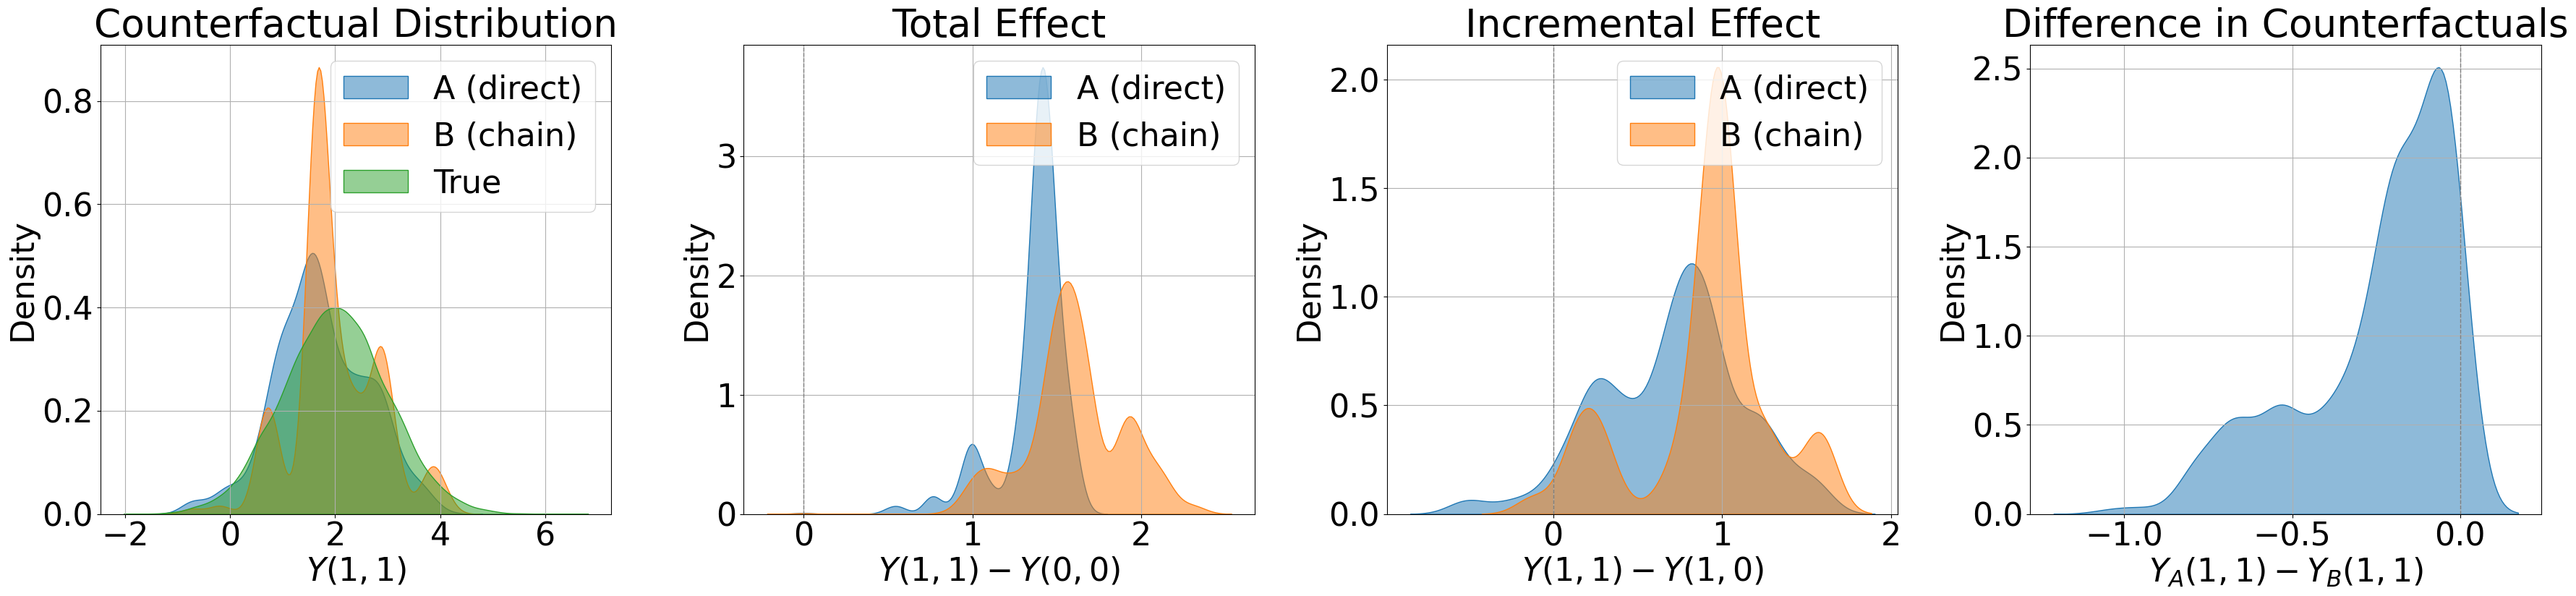

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute differences
diff_AB = (A["11"] - B["11"]).numpy()
diff_AC = (A["11"] - C["11"]).numpy()
diff_BC = (B["11"] - C["11"]).numpy()

# Set global font size
plt.rcParams.update({'font.size': 32})

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(36, 9))  # width x height in inches

## 1. Counterfactual Distribution at (1,1)
sns.kdeplot(A["11"], fill=True, alpha=0.5, label="A (direct)", ax=axes[0])
sns.kdeplot(B["11"], fill=True, alpha=0.5, label="B (chain)", ax=axes[0])
sns.kdeplot(Y11, fill=True, alpha=0.5, label="True", ax=axes[0])
axes[0].set_title("Counterfactual Distribution")
axes[0].set_xlabel(r"$Y(1,1)$")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

## 2. Incremental Effect: Y(1,1) - Y(1,0)
sns.kdeplot((A["11"] - A["00"]), fill=True, alpha=0.5, label="A (direct)", ax=axes[1])
sns.kdeplot((B["11"] - B["00"]), fill=True, alpha=0.5, label="B (chain)", ax=axes[1])
#sns.kdeplot(Y11 - Y10, fill=True, alpha=0.5, label="True", ax=axes[1])
axes[1].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[1].set_title("Total Effect")
axes[1].set_xlabel(r"$Y(1,1) - Y(0,0)$")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True)

## 2. Incremental Effect: Y(1,0) - Y(0,0)
sns.kdeplot((A["11"] - A["10"]), fill=True, alpha=0.5, label="A (direct)", ax=axes[2])
sns.kdeplot((B["11"] - B["10"]), fill=True, alpha=0.5, label="B (chain)", ax=axes[2])
#sns.kdeplot(Y10 - Y00, fill=True, alpha=0.5, label="True", ax=axes[2])
axes[2].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[2].set_title("Incremental Effect")
axes[2].set_xlabel(r"$Y(1,1) - Y(1,0)$")
axes[2].set_ylabel("Density")
axes[2].legend()
axes[2].grid(True)

## 3. Differences Between Strategies
sns.kdeplot(diff_AB, fill=True, label="A - B", alpha=0.5, ax=axes[3])
#sns.kdeplot(diff_AC, fill=True, label="A - C", alpha=0.5, ax=axes[3])
#sns.kdeplot(diff_BC, fill=True, label="B - C", alpha=0.5, ax=axes[3])
axes[3].axvline(0.0, linestyle='--', color='gray', linewidth=1)
axes[3].set_title("Difference in Counterfactuals")
axes[3].set_xlabel(r"$Y_A(1,1) - Y_B(1,1)$")
axes[3].set_ylabel("Density")
axes[3].grid(True)

# Tight layout and show
plt.tight_layout()
fig.savefig("KR_inconsistency.png", bbox_inches = "tight")
plt.show()

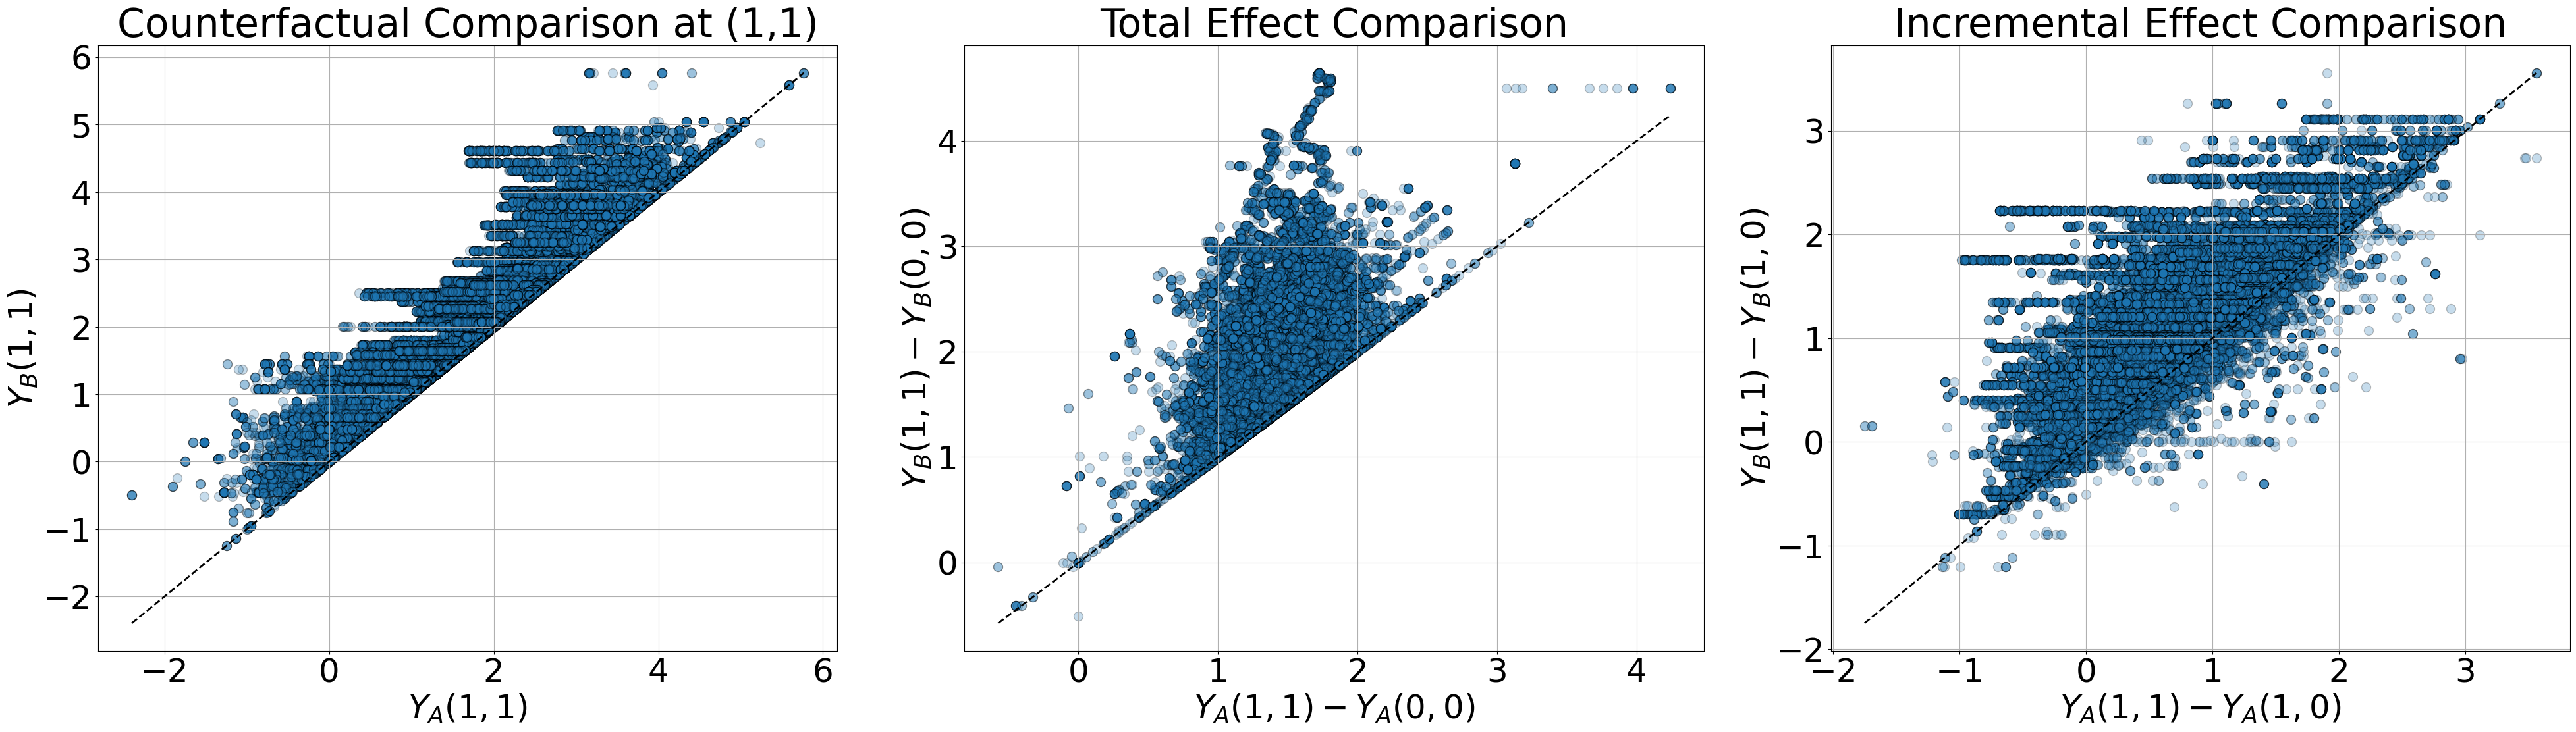

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Preallocate lists for concatenation
A_11_all, B_11_all = [], []
total_effect_A_all, total_effect_B_all = [], []
incremental_A_all, incremental_B_all = [], []

# Loop over experimental conditions
for Ak, Bk in zip(As, Bs):
    # Raw values
    A_11_all.append(Ak["11"].numpy())
    B_11_all.append(Bk["11"].numpy())

    # Total effect: Y(1,1) - Y(0,0)
    total_effect_A_all.append((Ak["11"] - Ak["00"]).numpy())
    total_effect_B_all.append((Bk["11"] - Bk["00"]).numpy())

    # Incremental effect: Y(1,1) - Y(1,0)
    incremental_A_all.append((Ak["11"] - Ak["10"]).numpy())
    incremental_B_all.append((Bk["11"] - Bk["10"]).numpy())

# Concatenate all across experiments
A_11 = np.concatenate(A_11_all)
B_11 = np.concatenate(B_11_all)
total_effect_A = np.concatenate(total_effect_A_all)
total_effect_B = np.concatenate(total_effect_B_all)
incremental_A = np.concatenate(incremental_A_all)
incremental_B = np.concatenate(incremental_B_all)

# Set global font size
plt.rcParams.update({'font.size': 36})

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(40, 12))

scatter_kwargs = dict(s=100, alpha=0.25, edgecolor='k')  # Bigger points with edge

# 1. Scatter: Y_A(1,1) vs Y_B(1,1)
axes[0].scatter(A_11, B_11, **scatter_kwargs)
axes[0].plot([A_11.min(), A_11.max()], [A_11.min(), A_11.max()], 'k--', lw=2)
axes[0].set_title("Counterfactual Comparison at (1,1)")
axes[0].set_xlabel(r"$Y_A(1,1)$")
axes[0].set_ylabel(r"$Y_B(1,1)$")
axes[0].grid(True)

# 2. Scatter: Y(1,1) - Y(0,0)
axes[1].scatter(total_effect_A, total_effect_B, **scatter_kwargs)
axes[1].plot([total_effect_A.min(), total_effect_A.max()],
             [total_effect_A.min(), total_effect_A.max()], 'k--', lw=2)
axes[1].set_title("Total Effect Comparison")
axes[1].set_xlabel(r"$Y_A(1,1) - Y_A(0,0)$")
axes[1].set_ylabel(r"$Y_B(1,1) - Y_B(0,0)$")
axes[1].grid(True)

# 3. Scatter: Y(1,1) - Y(1,0)
axes[2].scatter(incremental_A, incremental_B, **scatter_kwargs)
axes[2].plot([incremental_A.min(), incremental_A.max()],
             [incremental_A.min(), incremental_A.max()], 'k--', lw=2)
axes[2].set_title("Incremental Effect Comparison")
axes[2].set_xlabel(r"$Y_A(1,1) - Y_A(1,0)$")
axes[2].set_ylabel(r"$Y_B(1,1) - Y_B(1,0)$")
axes[2].grid(True)

# Layout and save
plt.tight_layout()
fig.savefig("KR_scatter_combined.png", bbox_inches="tight")
plt.show()

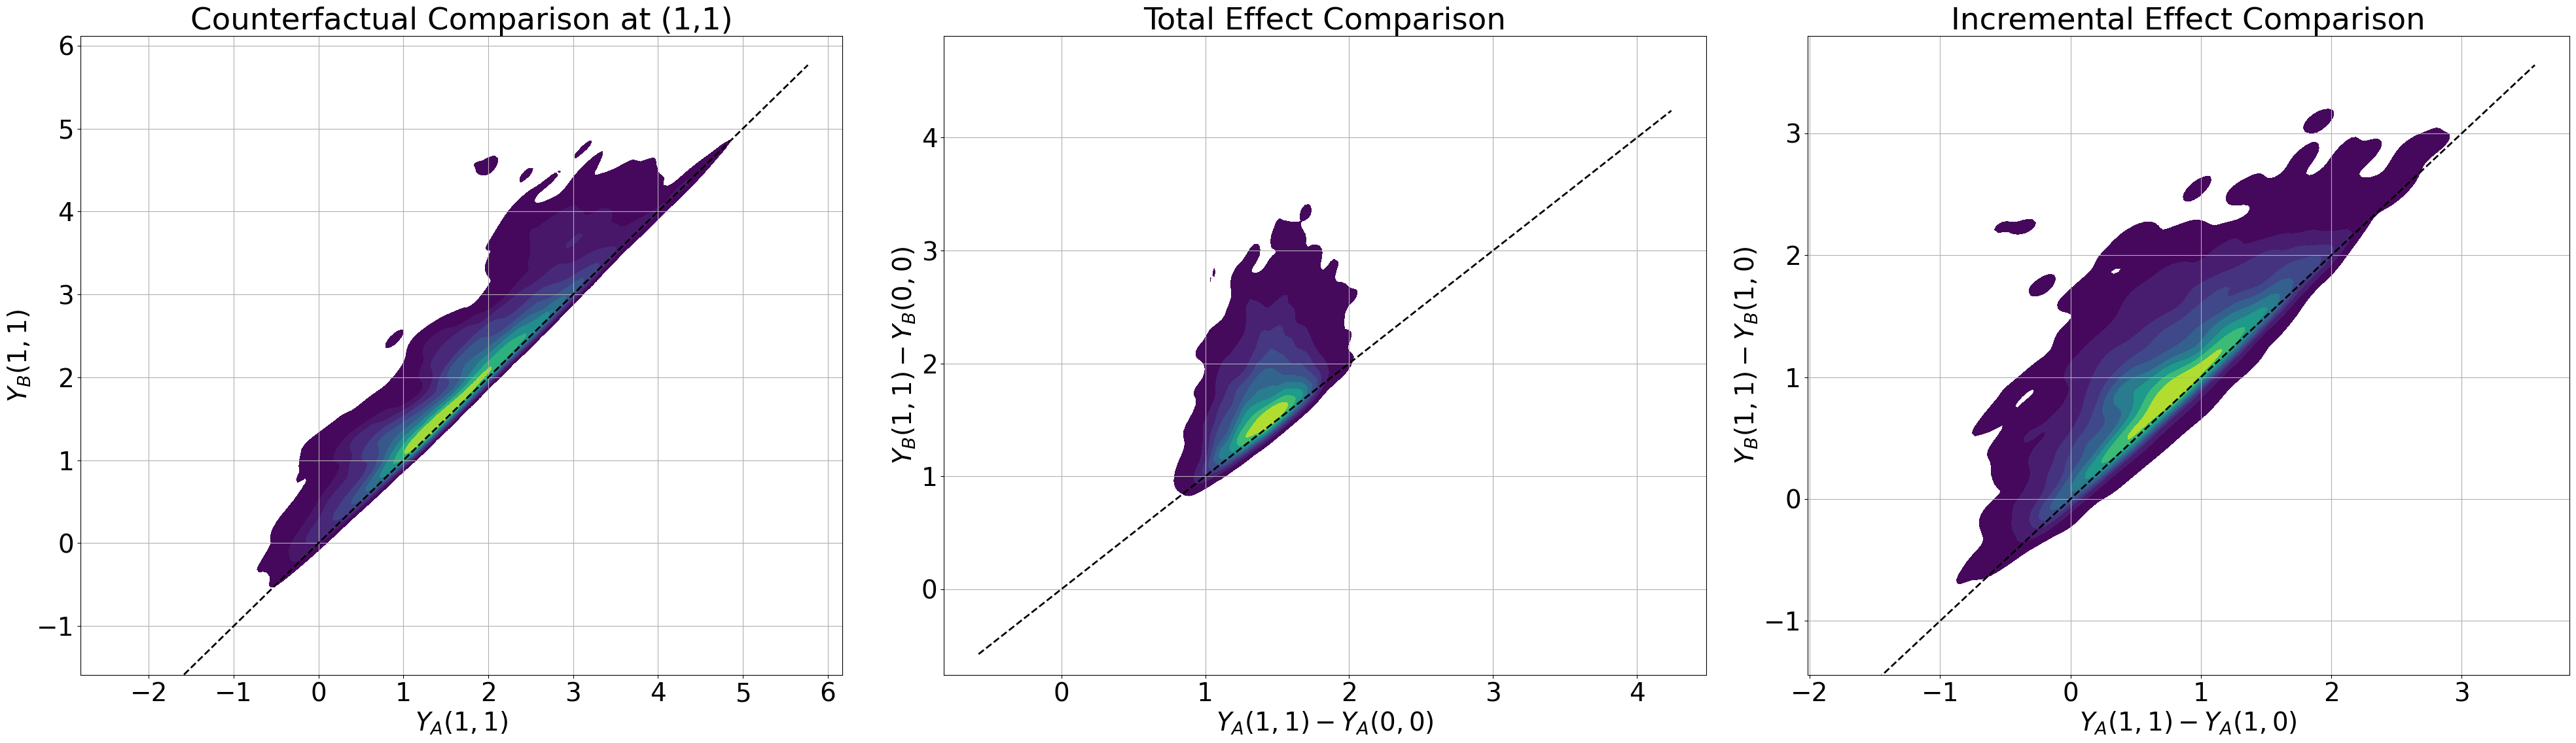

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preallocate lists for concatenation
A_11_all, B_11_all = [], []
total_effect_A_all, total_effect_B_all = [], []
incremental_A_all, incremental_B_all = [], []

# Loop over experimental conditions
for Ak, Bk in zip(As, Bs):
    A_11_all.append(Ak["11"].numpy())
    B_11_all.append(Bk["11"].numpy())
    total_effect_A_all.append((Ak["11"] - Ak["00"]).numpy())
    total_effect_B_all.append((Bk["11"] - Bk["00"]).numpy())
    incremental_A_all.append((Ak["11"] - Ak["10"]).numpy())
    incremental_B_all.append((Bk["11"] - Bk["10"]).numpy())

# Concatenate
A_11 = np.concatenate(A_11_all)
B_11 = np.concatenate(B_11_all)
total_effect_A = np.concatenate(total_effect_A_all)
total_effect_B = np.concatenate(total_effect_B_all)
incremental_A = np.concatenate(incremental_A_all)
incremental_B = np.concatenate(incremental_B_all)

# Set global font size
plt.rcParams.update({'font.size': 28})

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(40, 12))

kde_kwargs = dict(
    fill=True,
    thresh=0.05,
    levels=10,
    bw_adjust=1.0,
    cmap="viridis"
)

# Function to get padded x/y limits
def padded_limits(x, y, pad=0.05):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xpad = (xmax - xmin) * pad
    ypad = (ymax - ymin) * pad
    return (xmin - xpad, xmax + xpad), (ymin - ypad, ymax + ypad)

# 1. KDE: Y_A(1,1) vs Y_B(1,1)
sns.kdeplot(x=A_11, y=B_11, ax=axes[0], **kde_kwargs)
axes[0].plot([A_11.min(), A_11.max()], [A_11.min(), A_11.max()], 'k--', lw=2)
xlim, ylim = padded_limits(A_11, B_11)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title("Counterfactual Comparison at (1,1)")
axes[0].set_xlabel(r"$Y_A(1,1)$")
axes[0].set_ylabel(r"$Y_B(1,1)$")
axes[0].grid(True)

# 2. KDE: Y(1,1) - Y(0,0)
sns.kdeplot(x=total_effect_A, y=total_effect_B, ax=axes[1], **kde_kwargs)
axes[1].plot([total_effect_A.min(), total_effect_A.max()],
             [total_effect_A.min(), total_effect_A.max()], 'k--', lw=2)
xlim, ylim = padded_limits(total_effect_A, total_effect_B)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title("Total Effect Comparison")
axes[1].set_xlabel(r"$Y_A(1,1) - Y_A(0,0)$")
axes[1].set_ylabel(r"$Y_B(1,1) - Y_B(0,0)$")
axes[1].grid(True)

# 3. KDE: Y(1,1) - Y(1,0)
sns.kdeplot(x=incremental_A, y=incremental_B, ax=axes[2], **kde_kwargs)
axes[2].plot([incremental_A.min(), incremental_A.max()],
             [incremental_A.min(), incremental_A.max()], 'k--', lw=2)
xlim, ylim = padded_limits(incremental_A, incremental_B)
axes[2].set_xlim(xlim)
axes[2].set_ylim(ylim)
axes[2].set_title("Incremental Effect Comparison")
axes[2].set_xlabel(r"$Y_A(1,1) - Y_A(1,0)$")
axes[2].set_ylabel(r"$Y_B(1,1) - Y_B(1,0)$")
axes[2].grid(True)

# Layout and save
plt.tight_layout()
fig.savefig("KR_kde_comparison_padded.png", bbox_inches="tight")
plt.show()

In [12]:
A["11"].numpy().mean(),B["11"].numpy().mean(), C["11"].numpy().mean()

(1.7118479, 2.0553565, 1.7450109)

In [13]:
(A["11"]-A["00"]).numpy().mean(),(B["11"]-B["00"]).numpy().mean(), (C["11"]-C["00"]).numpy().mean()

(1.2167948, 1.5603033, 1.2499579)

In [14]:
(A["11"]-A["10"]).numpy().mean(),(B["11"]-B["10"]).numpy().mean(), (C["11"]-C["10"]).numpy().mean()

(0.09097086, 0.40982825, 0.09948264)

In [15]:
(A["10"]-A["00"]).numpy().mean(),(B["10"]-B["00"]).numpy().mean(), (C["10"]-C["00"]).numpy().mean()

(1.125824, 1.1504751, 1.1504751)